# Rank selection (outcome)

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from scipy.stats import zscore

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 12 16:30:19 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             48W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [4]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

Cloning into 'Tensor-Decompositions-OPM-MEG'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 229 (delta 92), reused 186 (delta 56), pack-reused 0 (from 0)
Receiving objects: 100% (229/229), 26.38 MiB | 26.22 MiB/s, done.
Resolving deltas: 100% (92/92), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 67.3 MB/s eta 0:00:00


In [5]:
mat_path = "outcome_pow_trial_chan_fbin_time_ds500_tpos.mat"

with h5py.File(mat_path, "r") as f:

    # --- main data ---
    # HDF5 reads MATLAB v7.3 arrays with transposed dimensions.
    # MATLAB Saved: [Trials, Chan, Freqs, Time]
    # Python Reads: (Time, Freqs, Chan, Trials)
    Pow = np.array(f["Pow"])

    freq = np.array(f["freq"]).squeeze()
    time = np.array(f["time"]).squeeze()

    freqs_hz = np.array(f["freqs_hz"]).squeeze()

    ds_fs = float(np.array(f["ds_fs"]).squeeze())
    fs_orig = float(np.array(f["fs_orig"]).squeeze())

    # --- channel labels (MATLAB cellstr) ---
    # MATLAB cell arrays of strings are stored as object references in HDF5
    ch_names_refs = f["chan_lbl"][()]
    chan_lbl = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        # MATLAB v7.3 stores strings as uint16 (utf-16le)
        chan_lbl.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    # --- MNE metadata ---
    mne_grp = f["mne"]

    ch_names_refs = mne_grp["ch_names"][()]
    mne_ch_names = []
    for r in ch_names_refs.flatten():
        s = f[r][()]
        mne_ch_names.append(s.tobytes().decode("utf-16le").rstrip("\x00"))

    ch_pos_m = np.array(mne_grp["ch_pos_m"], dtype=float)
    # MATLAB stored (N, 3), HDF5 reads (3, N). Transpose to get (N_chan, 3).
    if ch_pos_m.shape[0] == 3 and ch_pos_m.shape[1] != 3:
        ch_pos_m = ch_pos_m.T

    # Decode coordinate frame string (e.g., 'head')
    coord_frame_data = mne_grp["coord_frame"][()]
    try:
        coord_frame = coord_frame_data.tobytes().decode("utf-16le").rstrip("\x00")
    except AttributeError:
        # Fallback if it loaded as a simple byte string or char
        coord_frame = str(coord_frame_data)

In [6]:
Pow.shape

(751, 35, 121, 195)

In [7]:
Pow_T = Pow.T

In [8]:
Pow_T.shape

(195, 121, 35, 751)

In [9]:
log_Pow = np.log1p(Pow_T)

In [10]:
is_true = np.all(log_Pow >0)

is_true

np.True_

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_Pow_torch = torch.as_tensor(log_Pow, device=device, dtype=torch.float32)

In [12]:
log_Pow_torch.shape[0]

195

In [13]:
%cd Tensor-Decompositions-OPM-MEG/
from src.tools.rankselection import  rank_stability, stability_plot

/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [14]:
import tensorly as tl
tl.set_backend('pytorch')

In [15]:
from tqdm import tqdm

In [16]:
ranks = np.arange(1,21,1)

stabilities = []
stds = []

for i in tqdm(ranks):

    stability,std = rank_stability(log_Pow_torch,i,n_repeats=10)


    stabilities.append(stability)
    stds.append(std)

 55%|█████▌    | 11/20 [1:27:52<1:11:53, 479.31s/it]


KeyboardInterrupt: 

Text(0.5, 1.0, 'CP Rank Stability (ALS) - Outcome')

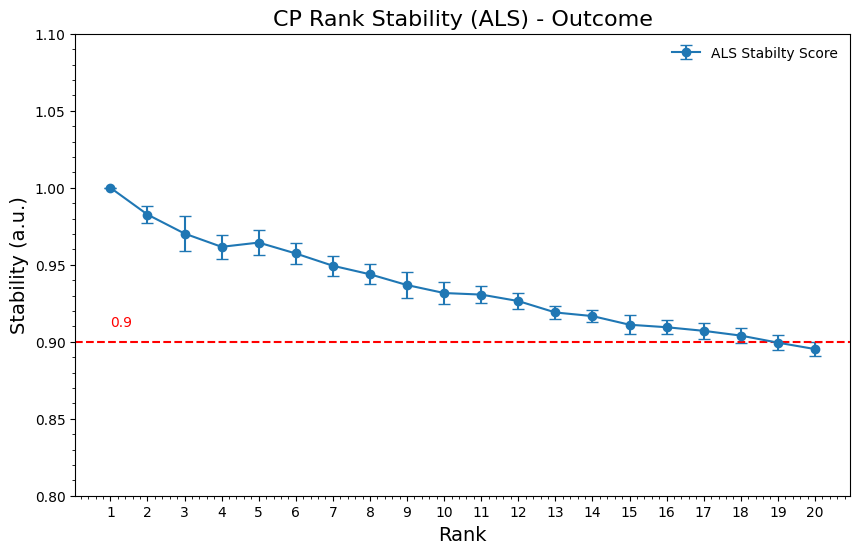

In [ ]:
stability_plot(ranks_v2,stabilities_v2,stds_v2)

plt.grid(False)
plt.ylim(0.8,1.1)
plt.title('CP Rank Stability (ALS) - Outcome',fontsize=16)

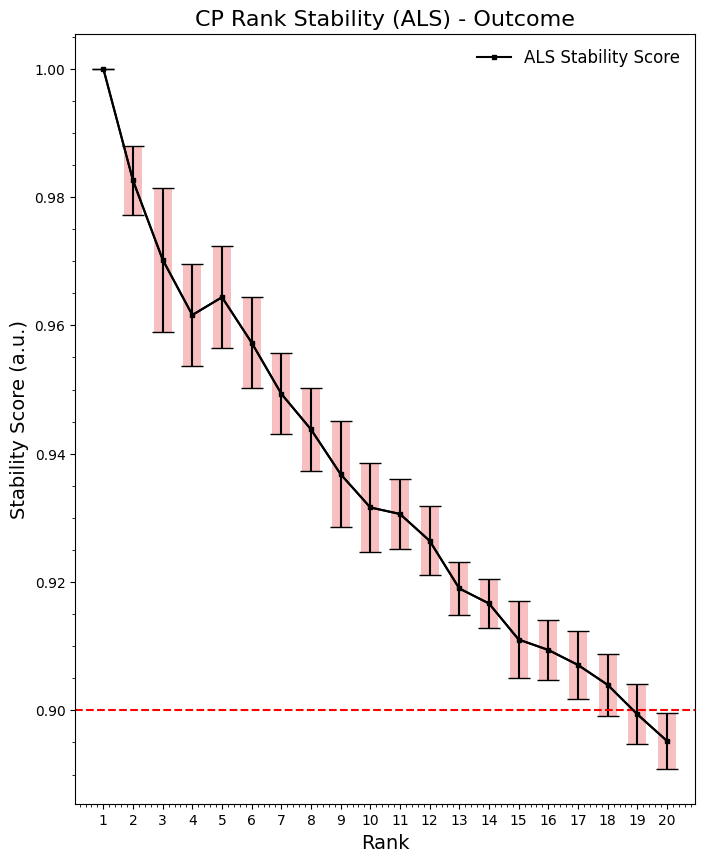

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.figure(figsize=(8, 10))
plt.plot(ranks_v2, stabilities_v2, marker='s',markersize=2.6,color='black',label='ALS Stability Score')
plt.errorbar(ranks_v2,stabilities_v2,stds_v2,capsize=8,color='black')

ax = plt.gca()

dx = 0.3
patches = []

for x, y, dy in zip(ranks_v2, stabilities_v2, stds_v2):
    patches.append(
        Rectangle(
            (x - dx, y - dy),
            2 * dx,
            2 * dy
        )
    )

pc = PatchCollection(patches,facecolor='lightcoral', edgecolor='none',linewidth=1.5,alpha=0.5)

ax.add_collection(pc)

plt.axhline(0.9, color='r', ls='--')
plt.legend(framealpha=0, fontsize=12)
plt.xlabel('Rank', fontsize=14)
plt.ylabel('Stability Score (a.u.)', fontsize=14)
plt.xticks(ranks_v2)
plt.title('CP Rank Stability (ALS) - Outcome', fontsize=16)
plt.minorticks_on()
plt.grid(False)

plt.show()


In [ ]:
from tensorly.decomposition import non_negative_parafac

In [ ]:
cp_tensor = non_negative_parafac(
            log_Pow_torch,
            rank=19,
            init="random",
            mask=None,
            n_iter_max=10000,
            tol=1e-9,
            random_state=None
        )

In [ ]:
from tensorly.cp_tensor import cp_normalize

def plot_factors(A, B, C, D):
    """
    Plots the factor matrices A, B, C, and D without subplots,
    each component in a separate figure.

    Parameters
    ----------
    A : np.ndarray
        Factor matrix for mode 0 (e.g., trials).
    B : np.ndarray
        Factor matrix for mode 1 (e.g., channels).
    C : np.ndarray
        Factor matrix for mode 2 (e.g., frequencies).
    D : np.ndarray
        Factor matrix for mode 3 (e.g., time).
    """

    R = A.shape[1]

    for r in range(R):
        fig, axes = plt.subplots(1, 4, figsize=(18, 4))
        fig.suptitle(f'Component {r+1}', fontsize=16)

        # Mode 0 (trials)
        axes[0].bar(range(A.shape[0]), A[:, r], color='tab:blue')
        axes[0].set_title('Trials')
        axes[0].set_ylabel('Amplitude')
        axes[0].set_xlabel('Trial Number')

        # Mode 1 (channels)
        axes[1].plot(B[:, r], color='tab:orange', ls='', marker='o')
        axes[1].set_title('Channels')
        axes[1].set_ylabel('Amplitude')
        axes[1].set_xlabel('Channel')
        #ax = axes[1]
        #Extract weights for the r-th component
        #component_data = B[:, r]
        #mne.viz.plot_topomap(component_data, info, axes=ax, show=False)


        # Mode 2 (freq)
        axes[2].plot(C[:, r], color='tab:green')
        axes[2].set_title('Frequency')
        axes[2].set_ylabel('Amplitude')
        axes[2].set_xlabel('Frequency (Hz)')

        # Mode 3 (time)
        axes[3].plot(np.linspace(0, 1500, D.shape[0]),D[:, r])
        axes[3].set_title('Time')
        axes[3].set_ylabel('Amplitude')
        axes[3].set_xlabel('Time (s)')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])



In [ ]:
cp_tensor_norm = cp_normalize(cp_tensor)

In [ ]:
_, factors = cp_tensor_norm

In [ ]:
factors.reverse()
A,B,C,D = factors

A = A.cpu().detach().numpy()
B = B.cpu().detach().numpy()
C = C.cpu().detach().numpy()
D = D.cpu().detach().numpy()

In [ ]:
A.shape

(195, 19)

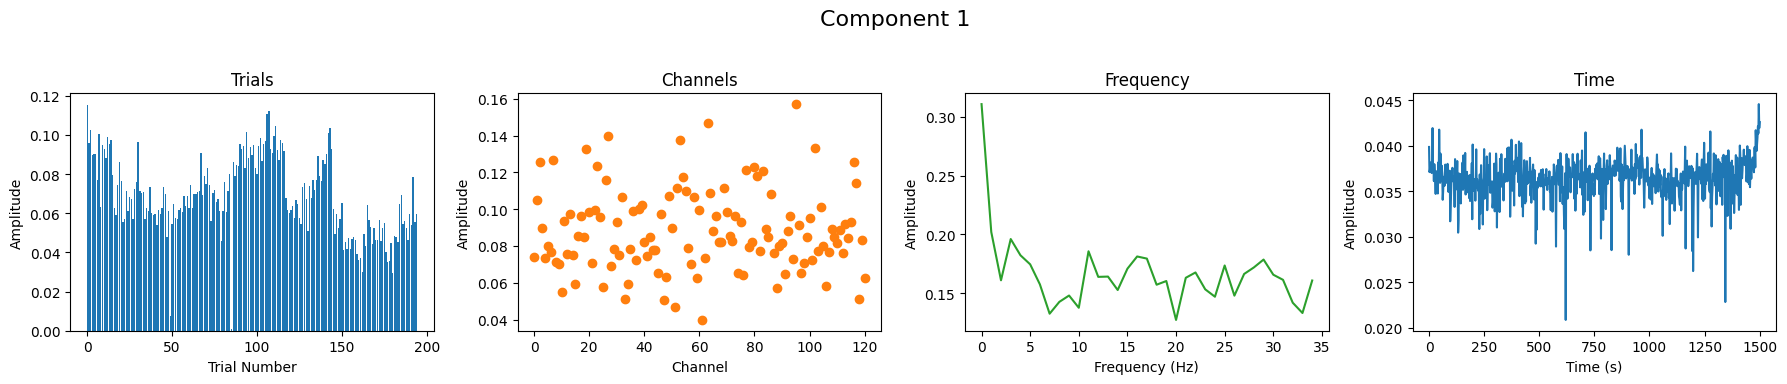

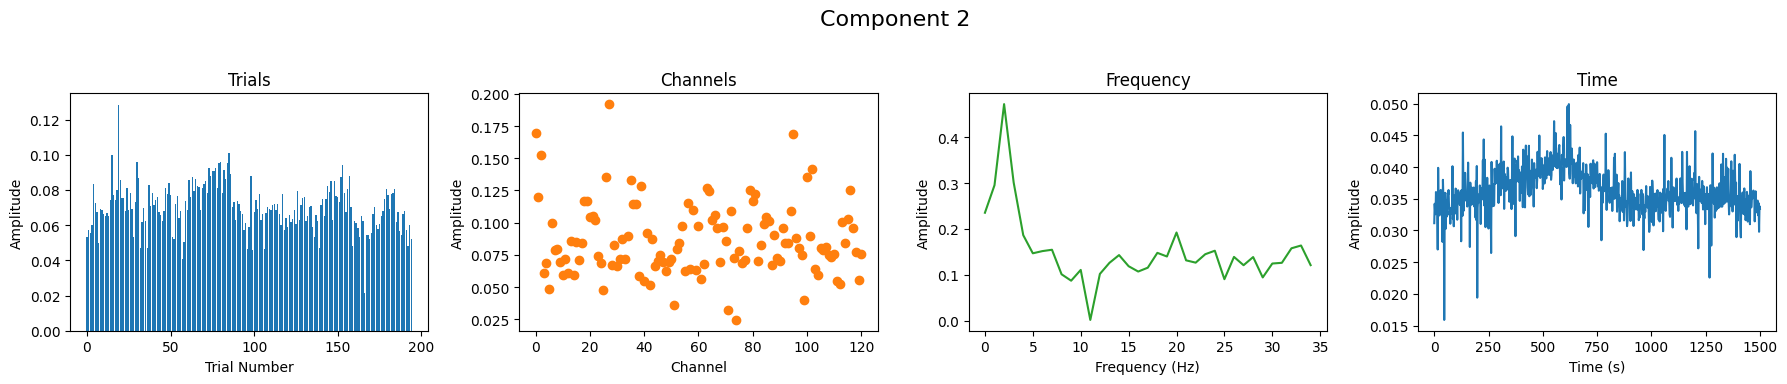

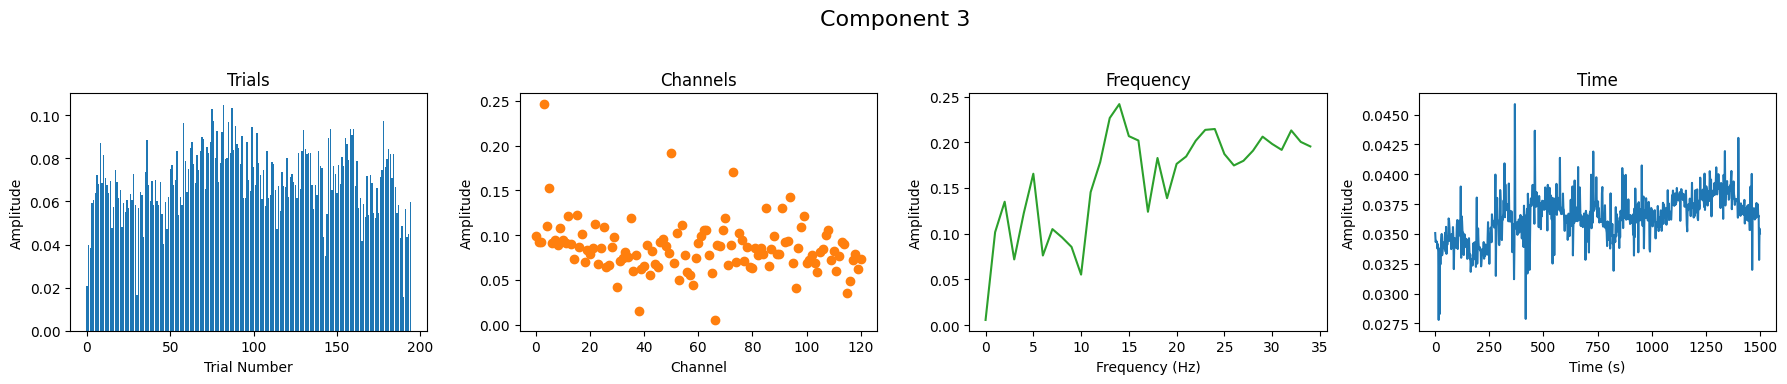

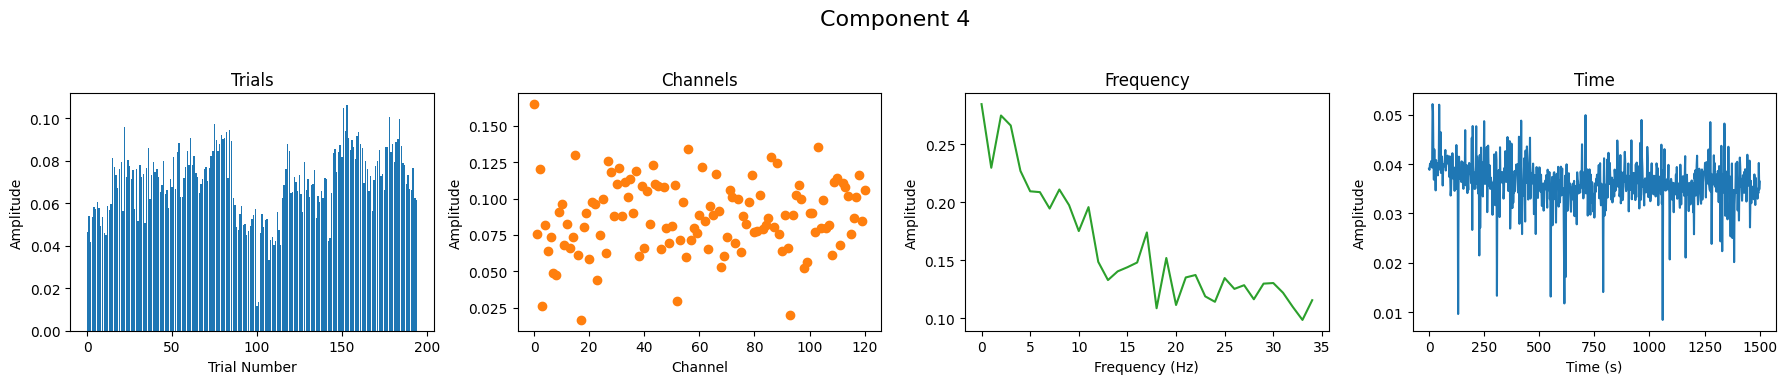

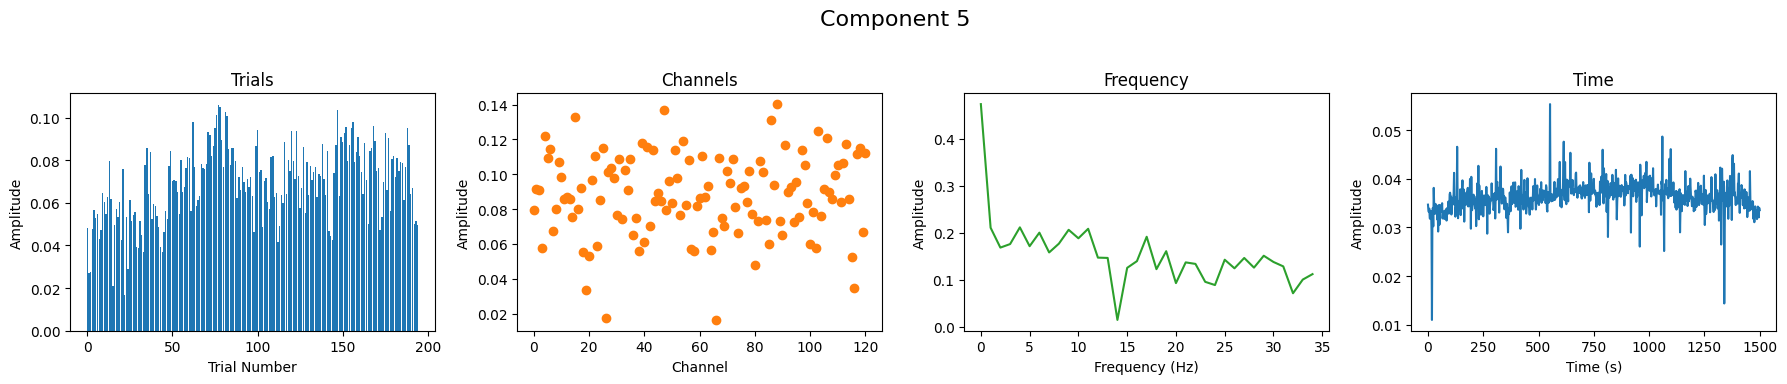

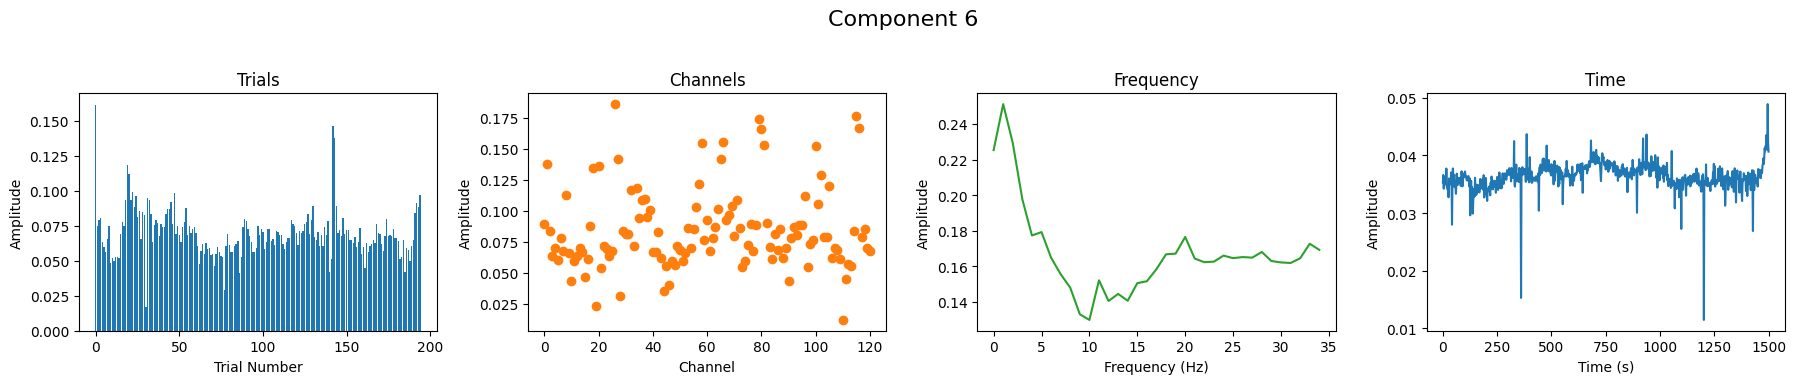

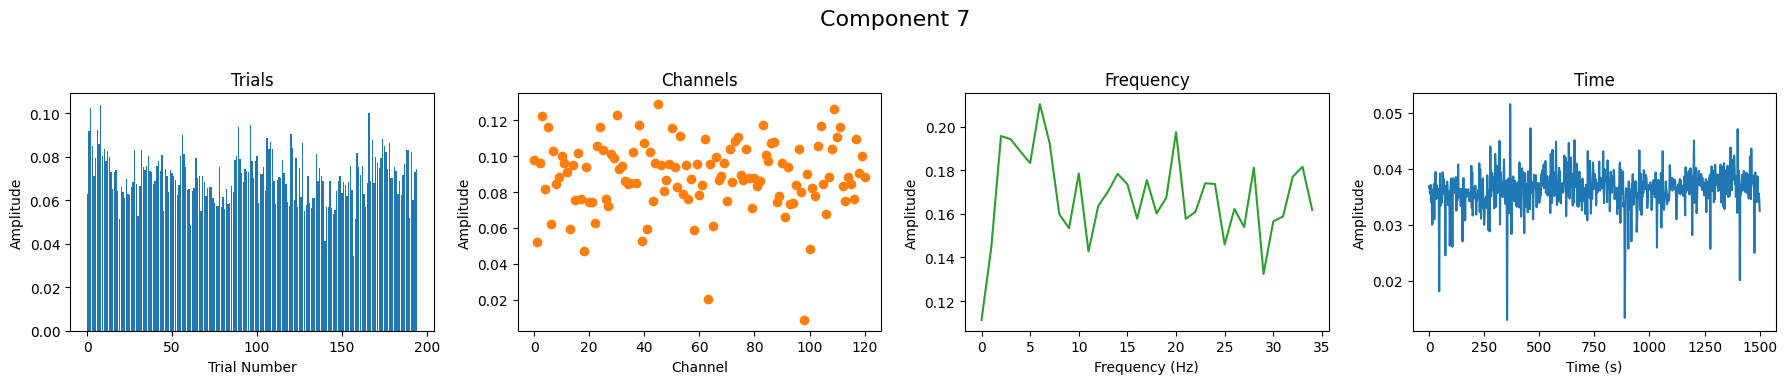

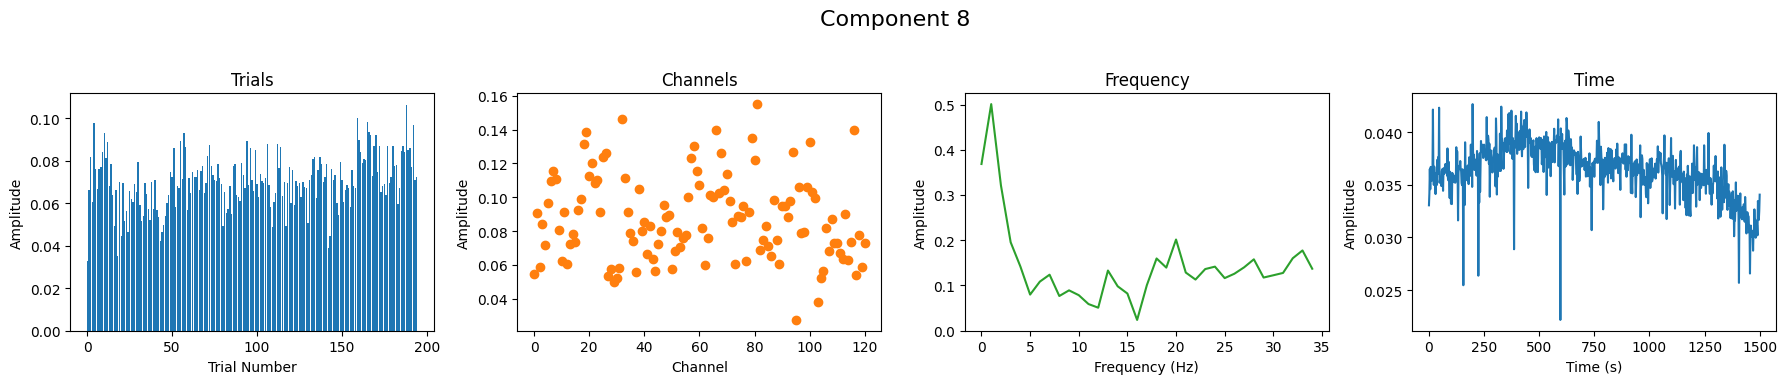

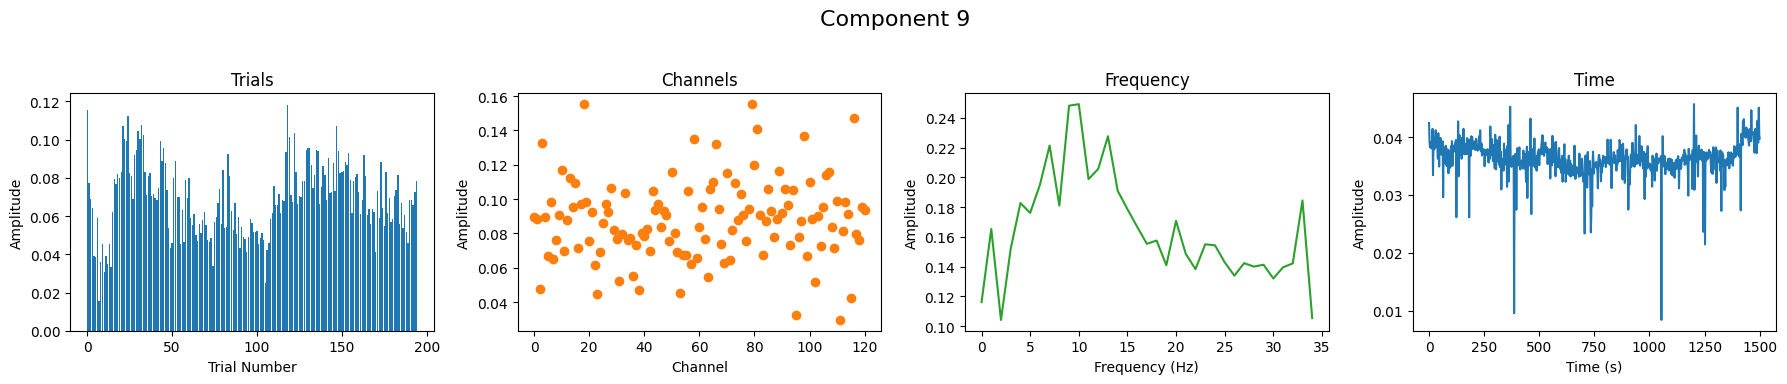

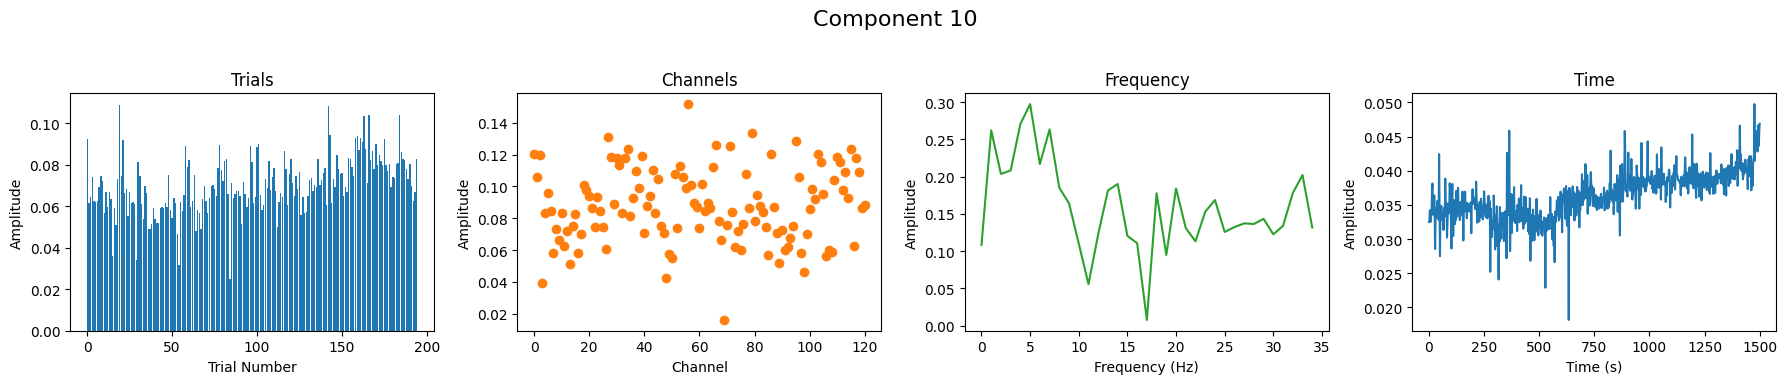

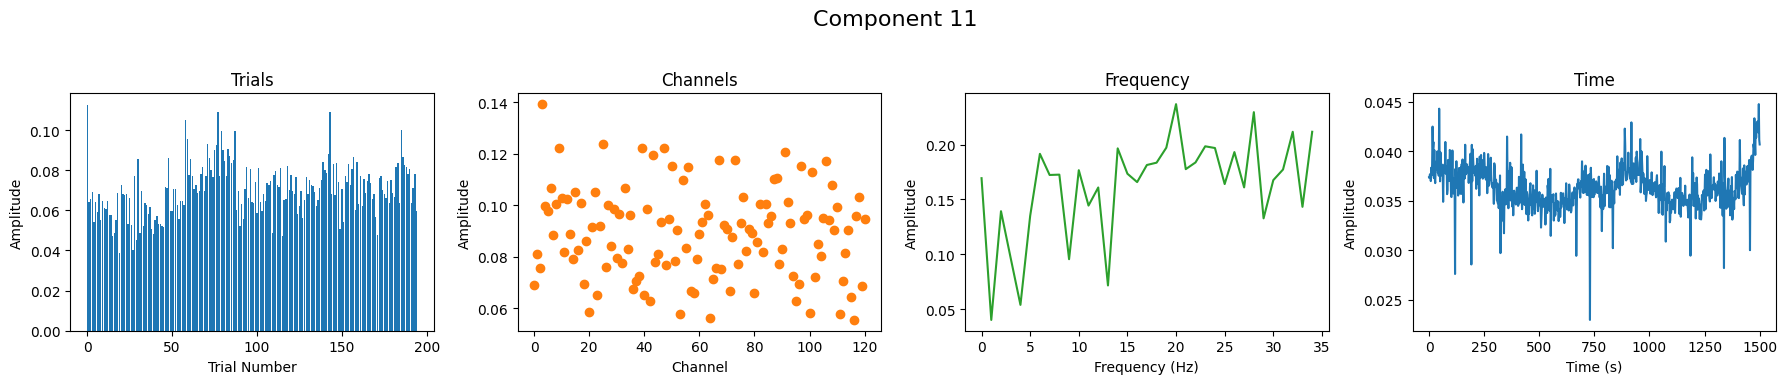

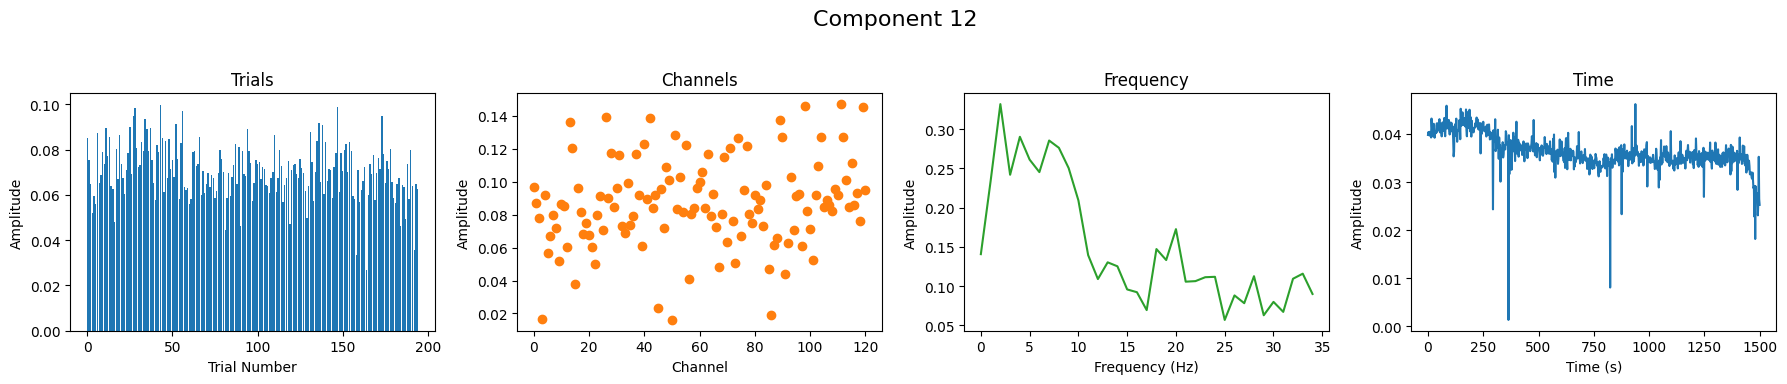

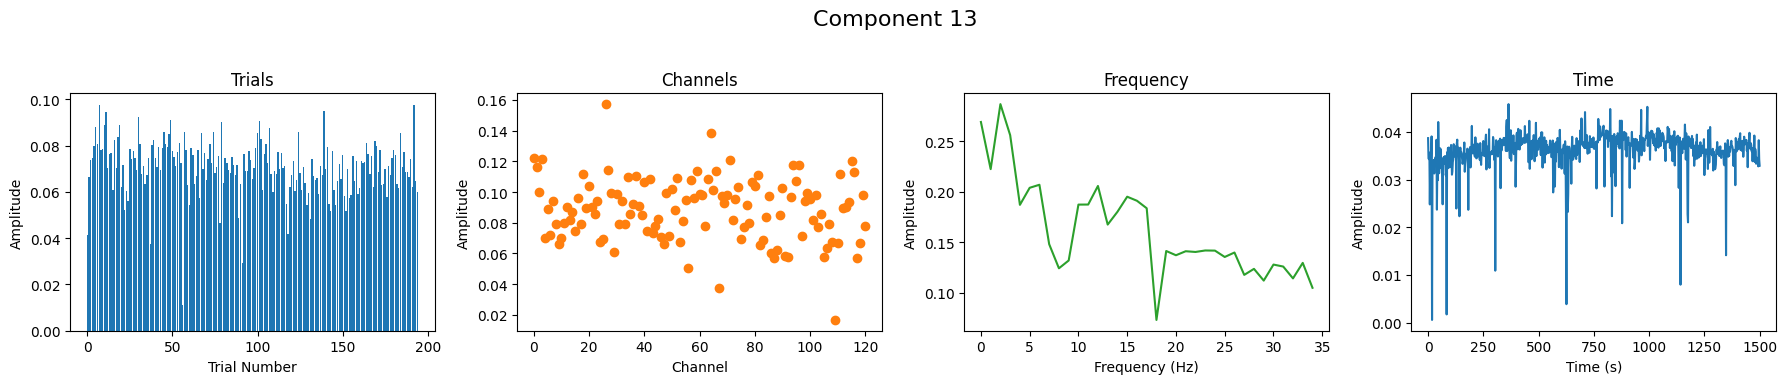

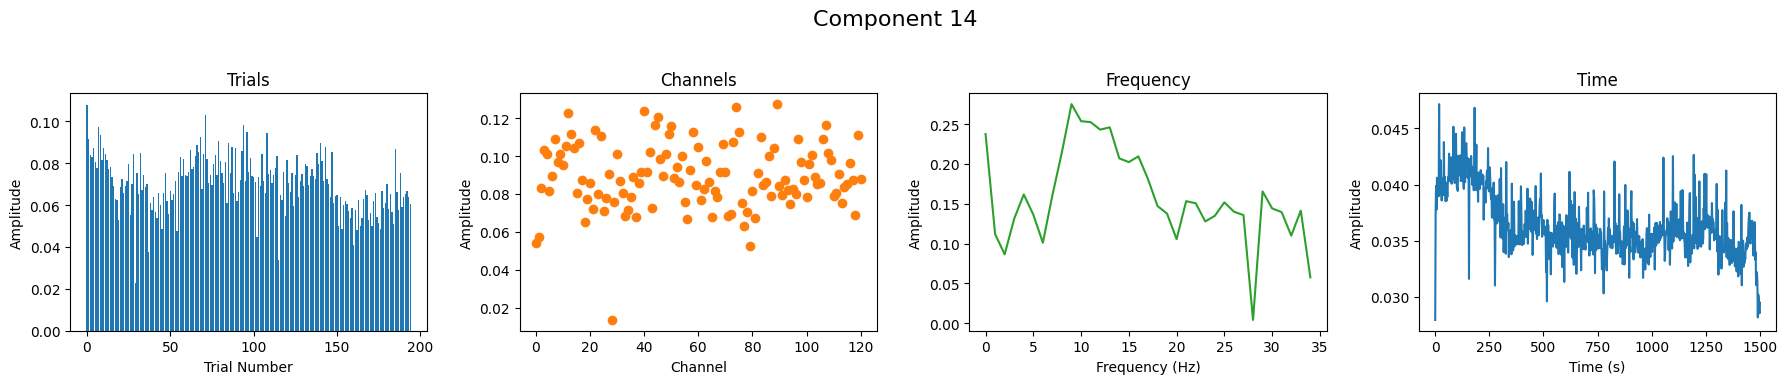

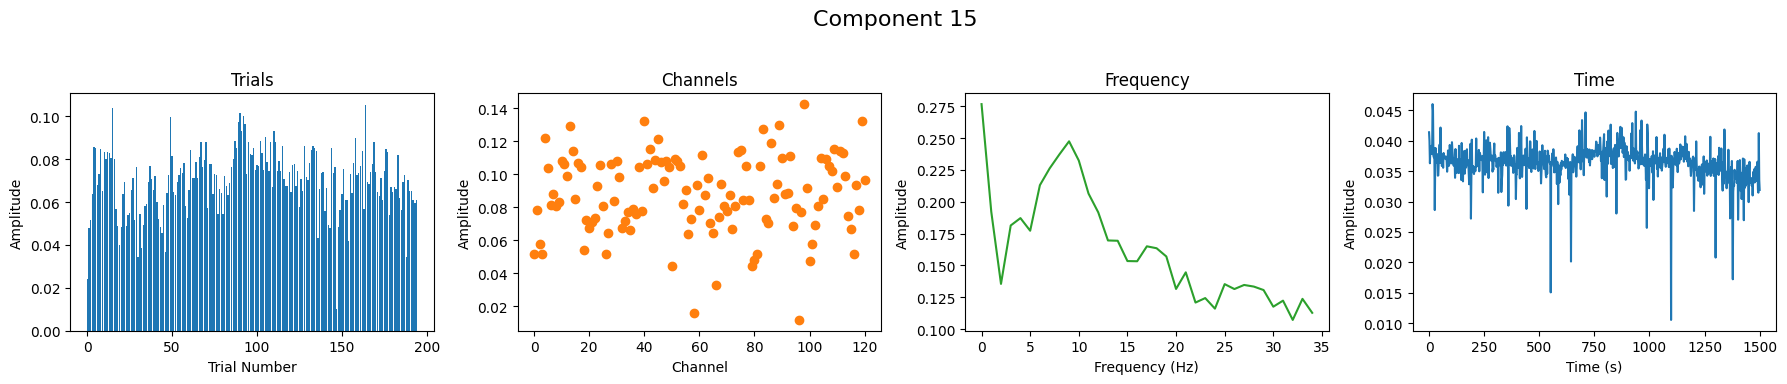

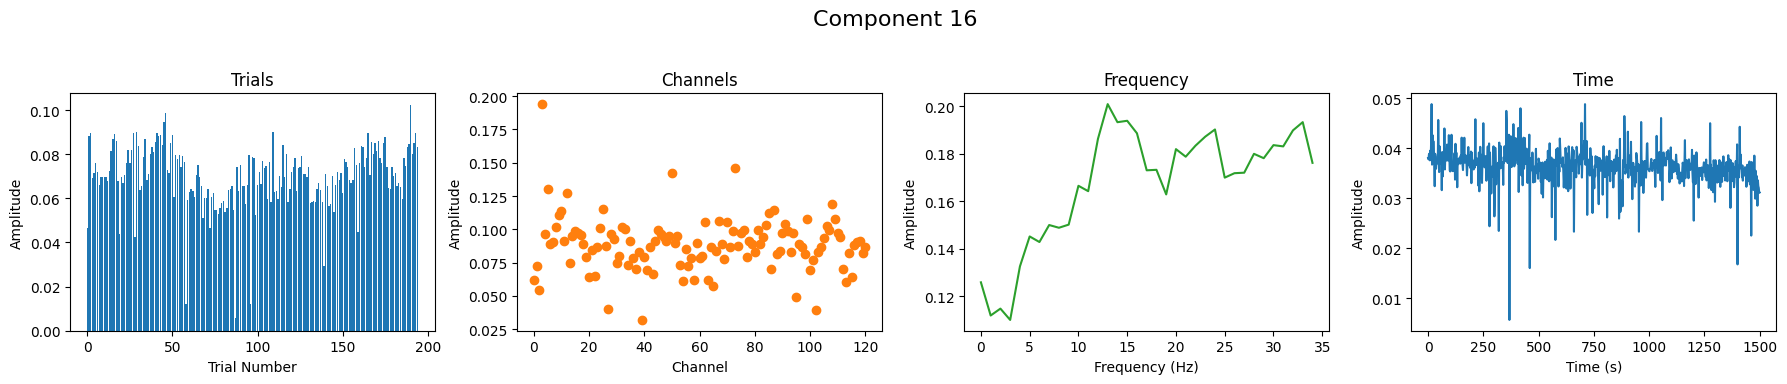

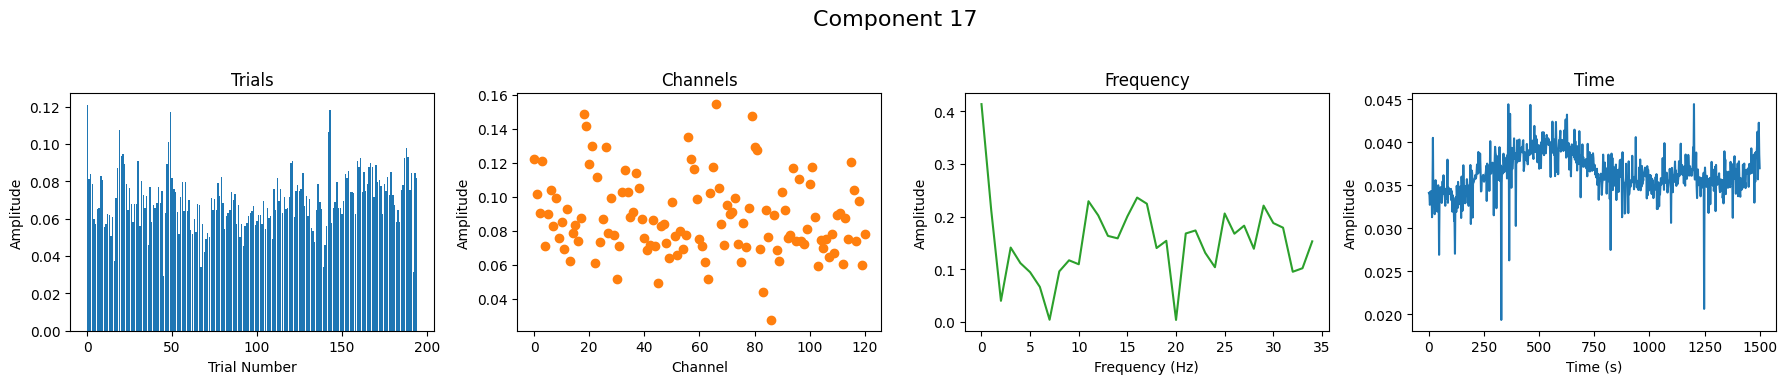

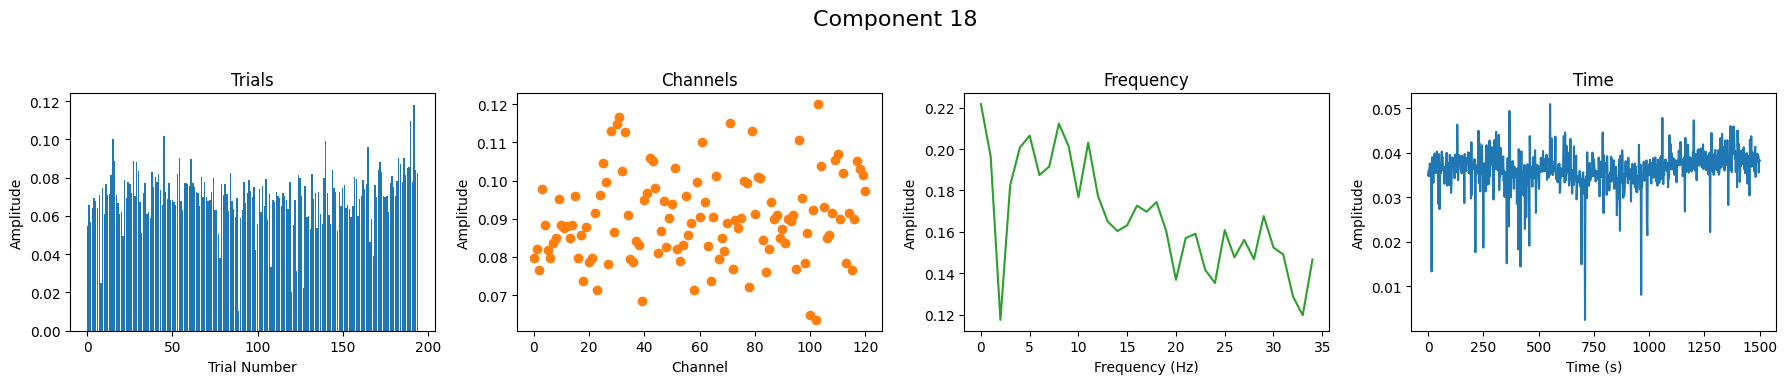

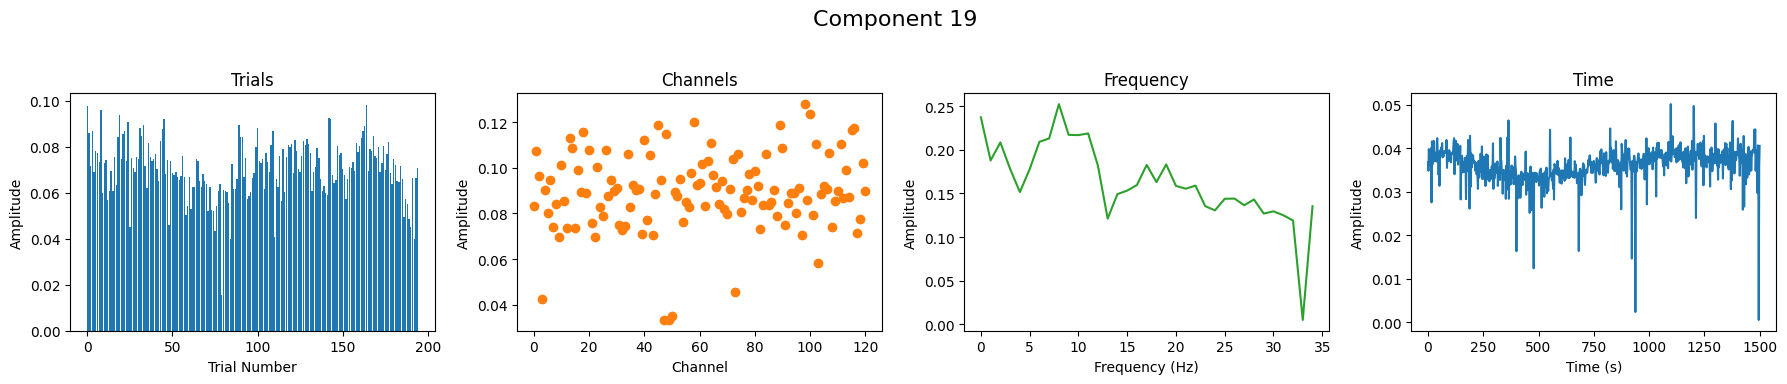

In [ ]:
plot_factors(A,B,C,D)

In [ ]:
win_vector = np.loadtxt('win-vector.csv',unpack=True)

<BarContainer object of 195 artists>

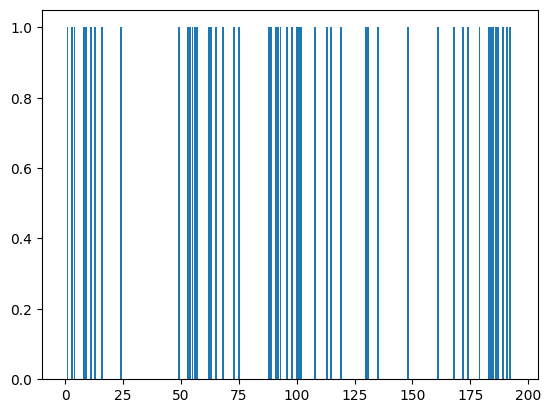

In [ ]:

plt.figure()
plt.bar(range(A.shape[0]),win_vector)

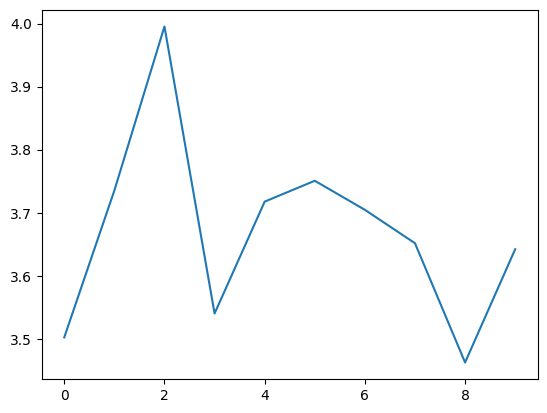

In [ ]:
plt.figure()
plt.plot(np.dot(win_vector,A))

In [ ]:
data = B[:,0]
ch_names = chan_lbl
ch_pos = ch_pos_m

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 140.6 MB/s eta 0:00:00


In [ ]:
import mne

In [ ]:
info = mne.create_info(ch_names=ch_names, sfreq=1000., ch_types='seeg')